In [2]:
pip install nltk

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 1.4 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 KB 225.5 kB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 KB 638.2 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 KB 489.9 kB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [17]:
import time
import json
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, length, avg, desc, udf
from pyspark.sql.types import FloatType
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

def strong_test(num_nodes, hdfs_host="192.168.2.156", master_host="192.168.2.156"):
    conf = SparkConf().setAppName(f"Reddit-Webis-TLDR-17 Analysis - {num_nodes} Nodes") \
        .set("spark.executor.instances", str(num_nodes))
    spark = SparkSession.builder \
        .master(f"spark://{master_host}:7077") \
        .config(conf=conf) \
        .appName("Reddit-Webis-TLDR-17 Analysis")\
        .getOrCreate()
    
    print(f"Running test with {num_nodes} executors")
    
    data_path = "hdfs://localhost:9000/user/ubuntu/corpus-webis-tldr-17.json"
    
    df = spark.read.json(data_path)
    df = df.dropna(subset=["content", "summary"])
    df = df.withColumn("content_length", length(col("content")))
    df = df.withColumn("summary_length", length(col("summary")))
    
    start_time = time.time()
    record_count = df.count()  
    end_time = time.time()
    
    execution_time = end_time - start_time
    print(f"Nodes: {num_nodes}, Data Size: {record_count} records, Execution Time: {execution_time:.2f} seconds")
    spark.stop()
    
    return execution_time, record_count


def run_scaling_tests(node_counts=[1, 2, 4, 8], runs_per_config=1):
    results = {}
    record_count = 0
    
    for nodes in node_counts:
        times = []
        for run in range(1, runs_per_config + 1):  
            print(f"\nStarting test with {nodes} nodes - Run {run}/{runs_per_config}")
            time_taken, records = strong_test(nodes)
            times.append(time_taken)
            record_count = records  
            print(f"{nodes:<6} | {run:<3} | {time_taken:<10.2f} | {records:<10}")
        
        avg_time = sum(times) / len(times)
        results[nodes] = avg_time
    
    base_time = results[node_counts[0]]
    for nodes, time in results.items():
        speedup = base_time / time
        efficiency = (speedup / nodes) * 100
        print(f"{nodes:<6} | {time:<12.2f} | {speedup:<10.2f}x | {efficiency:<10.2f}% | {record_count:<10}")
    
    return results

scaling_results = run_scaling_tests(node_counts=[1, 2, 4, 8], runs_per_config=1)




Starting test with 1 nodes - Run 1/1
Running test with 1 executors


[Stage 6:======================================================>  (24 + 1) / 25]

Nodes: 1, Data Size: 832607 records, Execution Time: 151.48 seconds


1      | 1   | 151.48     | 832607    

Starting test with 2 nodes - Run 1/1
Running test with 2 executors


Nodes: 2, Data Size: 832607 records, Execution Time: 57.21 seconds
2      | 1   | 57.21      | 832607    

Starting test with 4 nodes - Run 1/1
Running test with 4 executors


Nodes: 4, Data Size: 832607 records, Execution Time: 45.15 seconds
4      | 1   | 45.15      | 832607    

Starting test with 8 nodes - Run 1/1
Running test with 8 executors


Nodes: 8, Data Size: 832607 records, Execution Time: 49.67 seconds
8      | 1   | 49.67      | 832607    
1      | 151.48       | 1.00      x | 100.00    % | 832607    
2      | 57.21        | 2.65      x | 132.38    % | 832607    
4      | 45.15        | 3.35      x | 83.87     % | 832607    
8      | 49.67        | 3.05      x | 38.12     % | 832607    


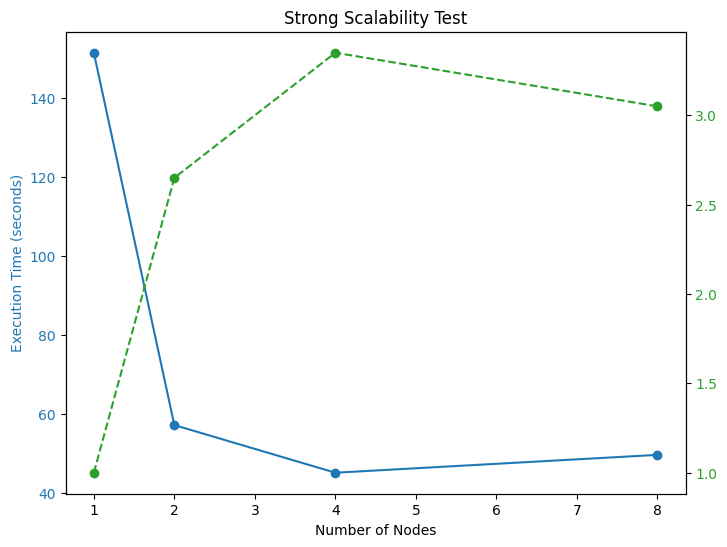

In [19]:
import matplotlib.pyplot as plt

nodes = [1, 2, 4, 8]
times = [151.48, 57.21, 45.15, 49.67]
speedup = [1.00, 2.65, 3.35, 3.05]

fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.set_xlabel('Number of Nodes')
ax1.set_ylabel('Execution Time (seconds)', color='tab:blue')
ax1.plot(nodes, times, color='tab:blue', marker='o', label='Execution Time')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(nodes, speedup, color='tab:green', marker='o', linestyle='--', label='Speedup')
ax2.tick_params(axis='y', labelcolor='tab:green')

plt.title('Strong Scalability Test')
plt.show()
